In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from comparers import ModelComparer
from util import RuleClassifier, get_complexity, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering, eval_clusterings, plot_2d_with_boundaries, plot_dependence_curves_for_nodes
from tasks.boston_housing import make_task4 as make_task
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from IPython.display import display
import shap
from shap.plots import bar
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

In [2]:
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection
filter_lines = lambda handles, labels: zip(*filter(lambda t: not isinstance(t[0], Line2D), zip(handles, labels)))
filter_paths = lambda handles, labels: zip(*filter(lambda t: not isinstance(t[0], PathCollection), zip(handles, labels)))

In [3]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names, name_b='C')

In [4]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

# Generate Explanations

In [6]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact', explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact', explanation_type='mclass_diff', space_type='log_odds')
with open('explanations/indiv.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('explanations/diffclf.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 247it [01:44,  2.23it/s]                         
Exact explainer: 247it [01:39,  2.22it/s]                         
Exact explainer: 247it [07:25,  1.86s/it]                         

CPU times: user 12min 7s, sys: 2min 13s, total: 14min 20s
Wall time: 10min 50s


In [6]:
%%time
node = make_clustering(comparer, indiv_shap_values, diffclf_shap_values,
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions)
for class_name in comparer.class_names:
    print(class_name)
    node.focus_class = class_name
    node.calculate_counterfactuals()
with open(f'explanations/clustering.pickle', 'wb') as f:
    pickle.dump(node.state, f)

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)
CPU times: user 23min 11s, sys: 8.19 s, total: 23min 20s
Wall time: 23min 55s


In [5]:
with open('explanations/diffclf.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)
with open('explanations/indiv.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)
with open(f'explanations/clustering.pickle', 'rb') as f:
    state = pickle.load(f)
node = make_clustering(comparer, indiv_shap_values, diffclf_shap_values, focus_class=None,
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions, state=state)

# Individual Explanations

In [6]:
node.focus_class = None

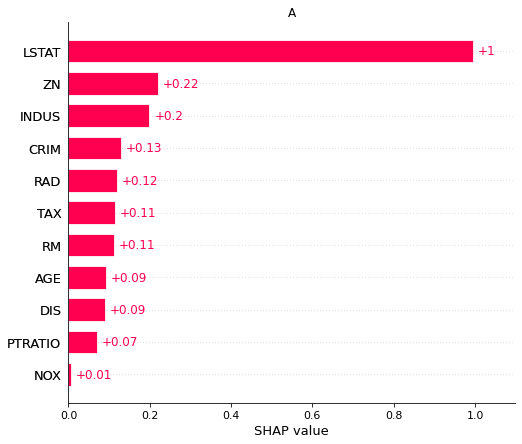

In [7]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, ['A.0', 'A.1', 'A.2']])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

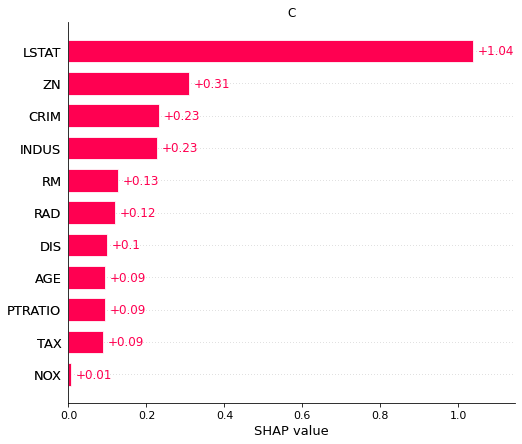

In [8]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, ['C.0', 'C.1', 'C.2']])
plot_feature_importance_bar(feature_importance, 'C', feature_order)
with open('../explanations/featimp-c.pickle', 'wb') as f:
    pickle.dump(feature_importance.values, f)

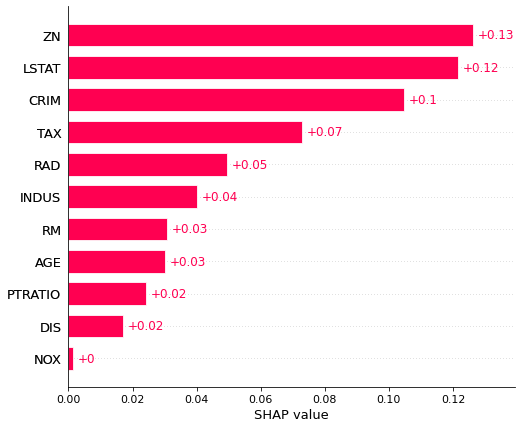

In [9]:
plot_feature_importance_bar(node.diff_feature_importances, feature_order=node.diff_feature_order)
plt.savefig('figures/boston4-diff-feat-imp.pdf', bbox_inches='tight', pad_inches=0)

In [10]:
node.diff_shap_values.base_values[0, :]

array([-0.12023363, -0.04718345, -0.10573555])

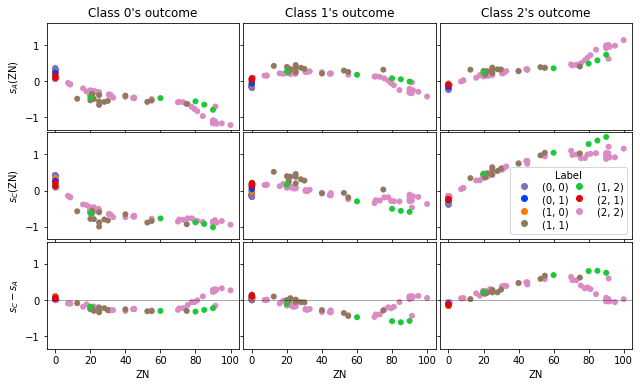

In [11]:
node.plot_indiv_feature_dependence(feature_names[node.diff_feature_order[0]], show_legend=False)
plt.gca().figure.axes[5].legend(title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/boston4-indiv-depplots-zn.pdf', bbox_inches='tight', pad_inches=0)

In [12]:
from clustering import plot_dependence_curves_for_feature

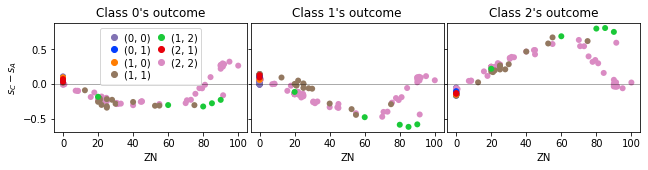

In [13]:
plot_dependence_curves_for_feature(node, 'ZN', kind='indiv-diff', show_label_legend=False)
plt.gca().figure.axes[0].legend(ncol=2, handleheight=1.5, columnspacing=0.01, labelspacing=0.01, handletextpad=0.001)
plt.savefig('figures/boston4-indiv-depplots-zn.pdf', bbox_inches='tight', pad_inches=0)

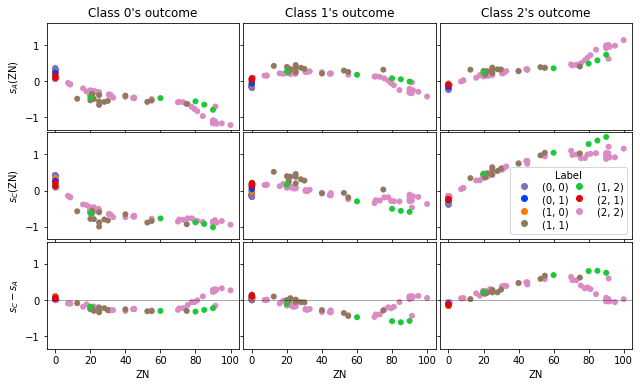

In [14]:
node.plot_indiv_feature_dependence(feature_names[node.diff_feature_order[0]], show_legend=False)
plt.gca().figure.axes[5].legend(title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/boston4-indiv-depplots-zn.pdf', bbox_inches='tight', pad_inches=0)

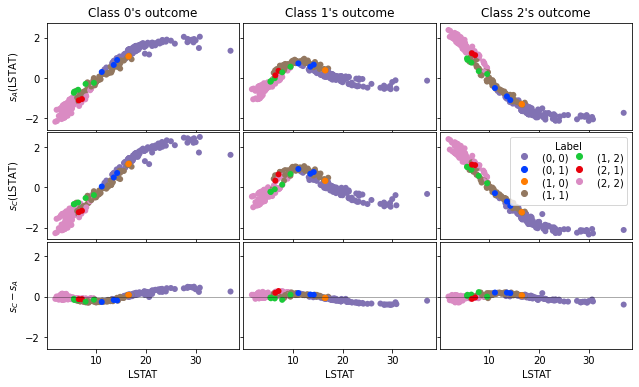

In [15]:
node.plot_indiv_feature_dependence(feature_names[node.diff_feature_order[1]], show_legend=False)
plt.gca().figure.axes[5].legend(title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)

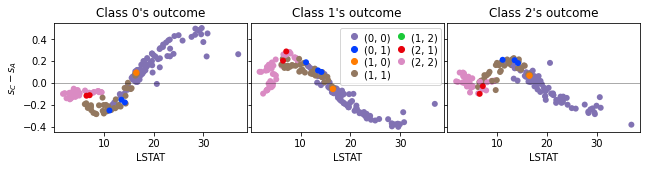

In [16]:
plot_dependence_curves_for_feature(node.filter('ZN == 0'), 'LSTAT', kind='indiv-diff', show_label_legend=False)
ax = plt.gca()
ax.figure.legend(*ax.get_legend_handles_labels(), loc='center', bbox_to_anchor=(0.57, 0.65), ncol=2, handleheight=1.5, columnspacing=0.01, labelspacing=0.01, handletextpad=0.001)
plt.savefig('figures/boston4-indiv-depplots-lstat.pdf', bbox_inches='tight', pad_inches=0)

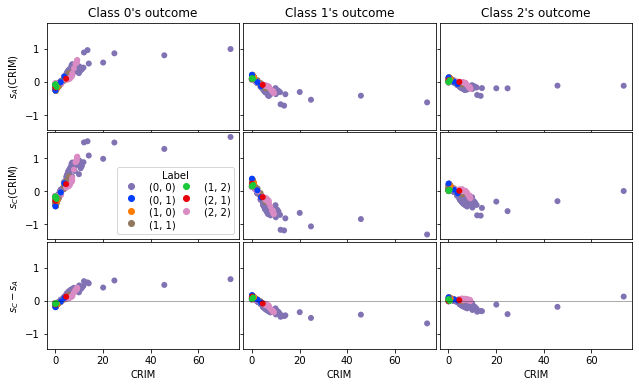

In [17]:
node.plot_indiv_feature_dependence(feature_names[node.diff_feature_order[2]], show_legend=False)
plt.gca().figure.axes[3].legend(title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/boston4-indiv-depplots-crim.pdf', bbox_inches='tight', pad_inches=0)

In [18]:
from clustering import plot_dependence_curves_for_nodes

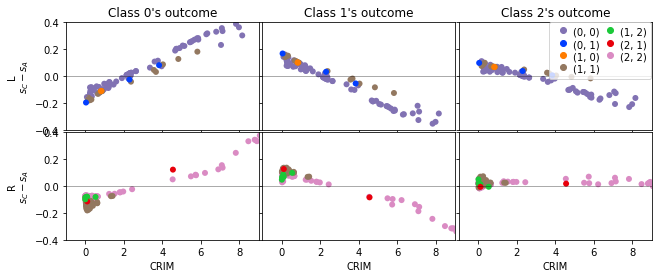

In [19]:
plot_dependence_curves_for_nodes(node.descend().get_left(), node.descend().get_right(),
                                 feature='CRIM', kind='indiv-diff', show_legend=False)
ax = plt.gca()
ax.set_xlim((-1, 9))
ax.set_ylim((-0.4, 0.4))
ax.figure.legend(*ax.get_legend_handles_labels(), loc='upper right', bbox_to_anchor=(0.905, 0.9), ncol=2, handleheight=1.5, columnspacing=0.01, labelspacing=0.01, handletextpad=0.001)
#plt.savefig('figures/boston4-indiv-depplots-crim.pdf', bbox_inches='tight', pad_inches=0)

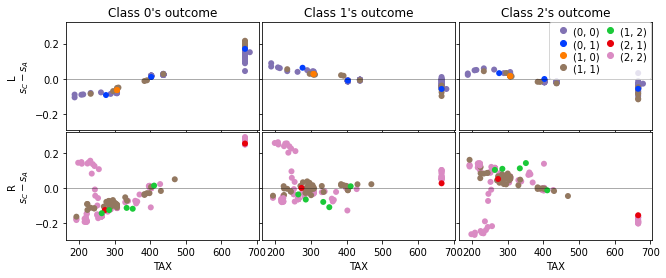

In [20]:
plot_dependence_curves_for_nodes(node.descend().get_left(), node.descend().get_right(),
                                 feature='TAX', kind='indiv-diff', show_legend=False)
ax = plt.gca()
ax.figure.legend(*ax.get_legend_handles_labels(), loc='upper right', bbox_to_anchor=(0.905, 0.9), ncol=2, handleheight=1.5, columnspacing=0.01, labelspacing=0.01, handletextpad=0.001)

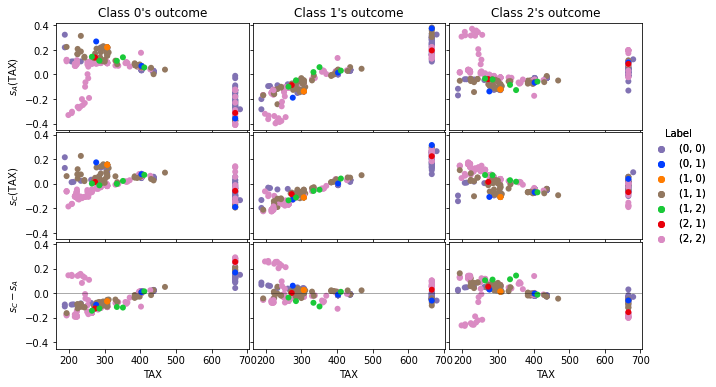

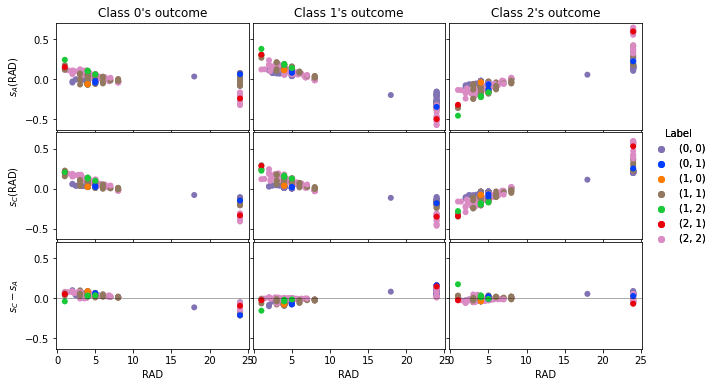

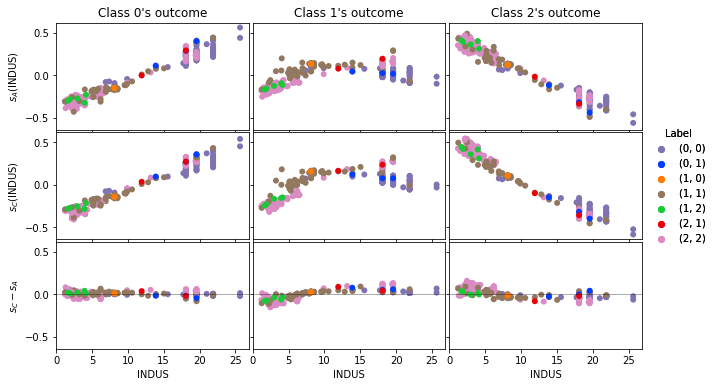

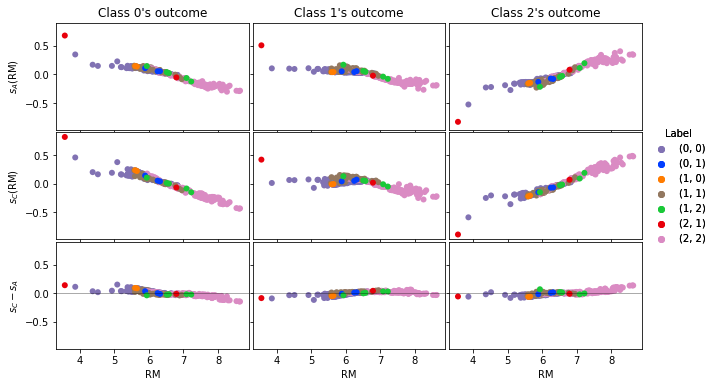

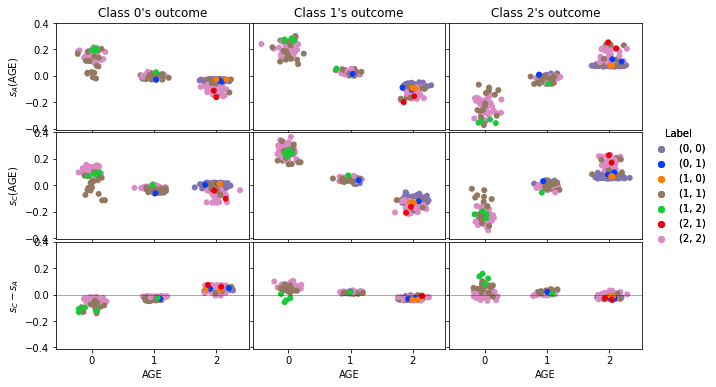

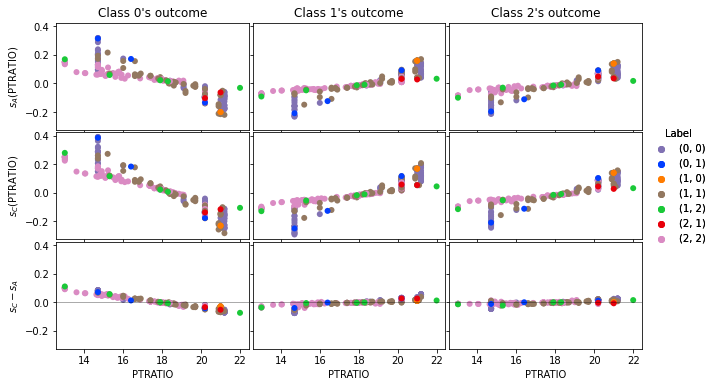

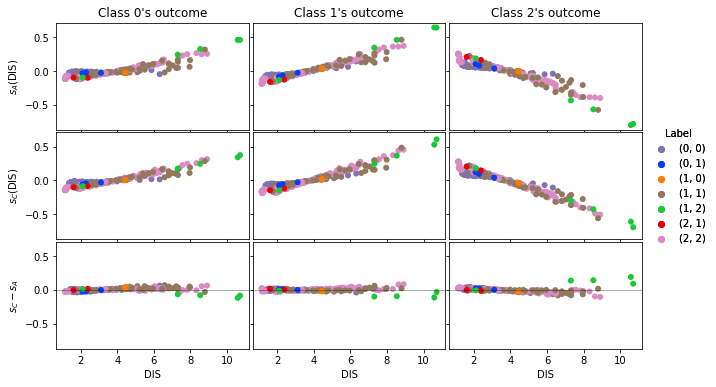

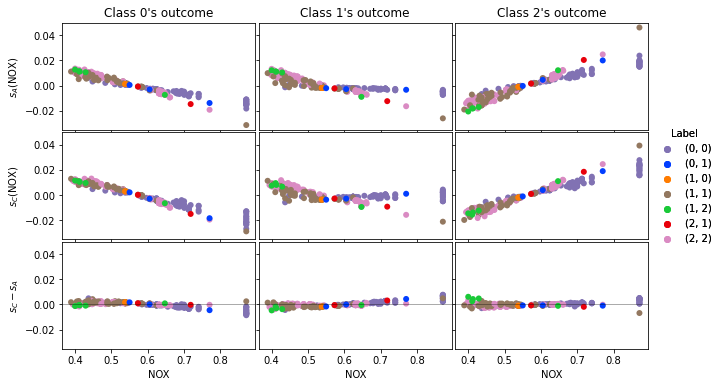

In [21]:
node.plot_indiv_feature_dependence(*feature_names[node.diff_feature_order[3:]])

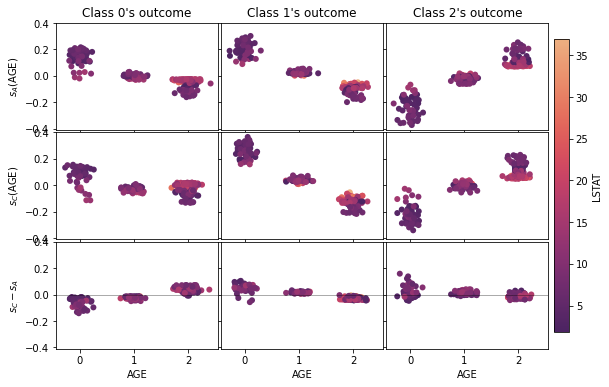

In [22]:
node.plot_indiv_feature_dependence('AGE', color='LSTAT')

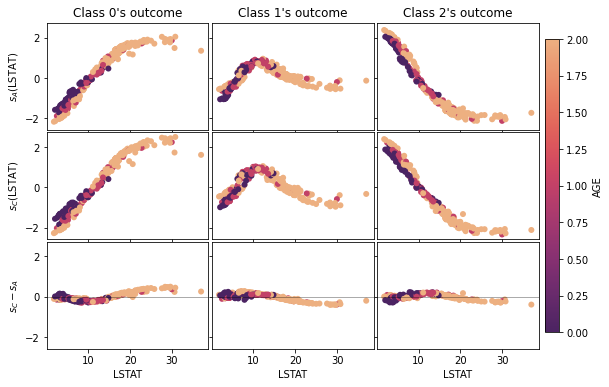

In [23]:
node.plot_indiv_feature_dependence('LSTAT', color='AGE')

# Difference Classifier Explanations

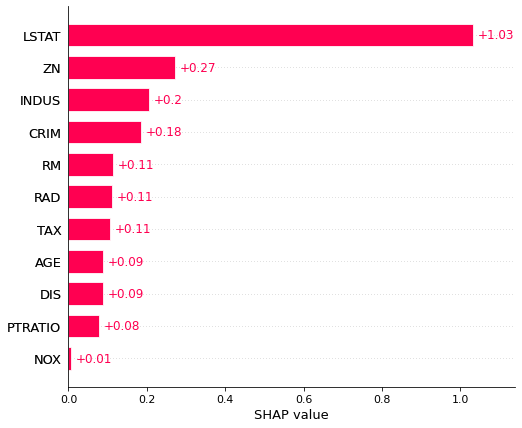

In [24]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

## $(0,1)$

In [25]:
node.focus_class = '(0, 1)'
node.class_counts, node.distance
classes = ['(0, 0)', '(0, 1)', '(1, 1)']

In [26]:
print(node.rule_from_counterfactuals()[0])

10.48 < LSTAT <= 14.89 and ZN <= 1 and 12.37 < INDUS <= 22.10 and CRIM <= 4.3 and 4.81 < RM <= 7.33 and AGE > 0 and DIS <= 6.59 and 13.36 < PTRATIO <= 20.73


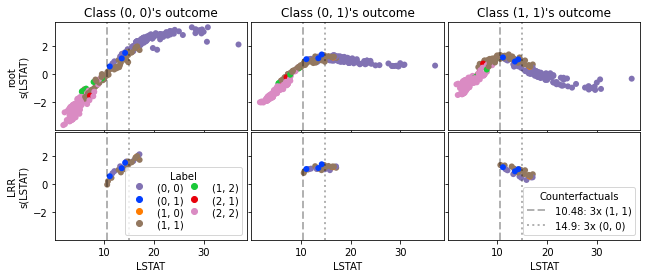

In [27]:
node.plot_feature_dependence(feature_names[node.diffclf_feature_order[0]], classes=classes, focus=node.descend(), show_legend=False)
ax = plt.gca().figure.axes[3]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/boston4-depplots-01-lstat.pdf', bbox_inches='tight', pad_inches=0)

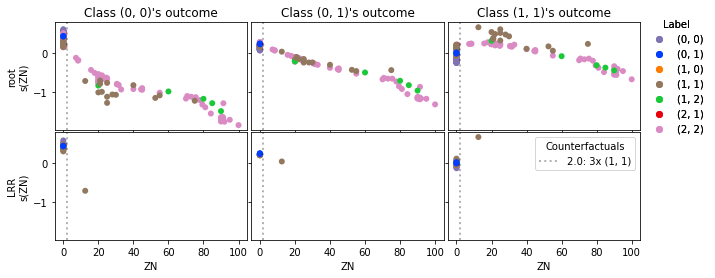

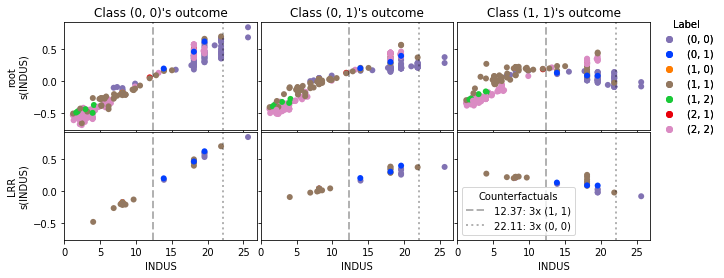

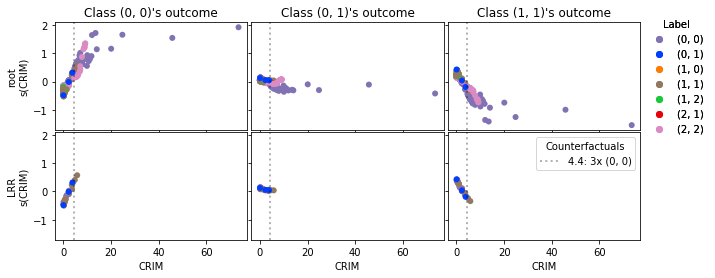

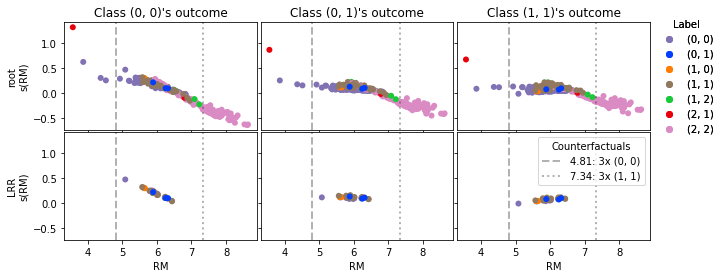

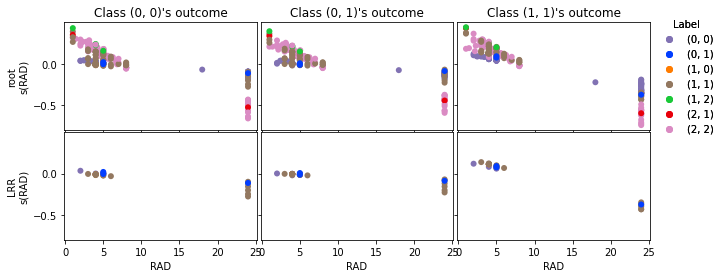

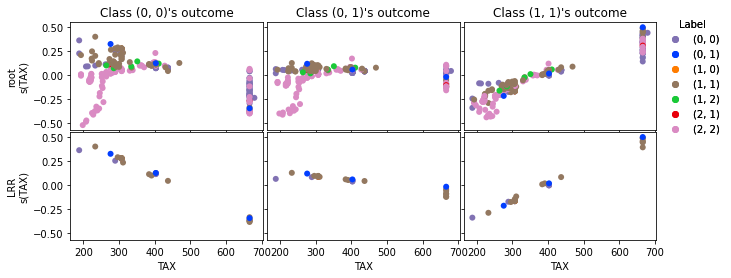

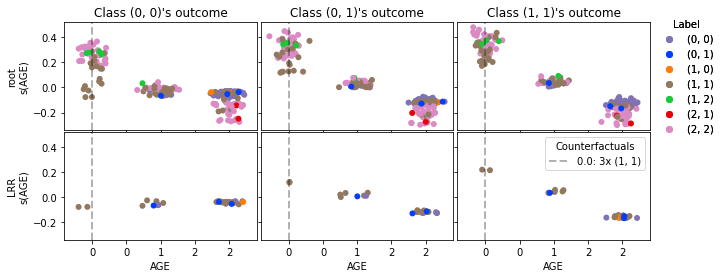

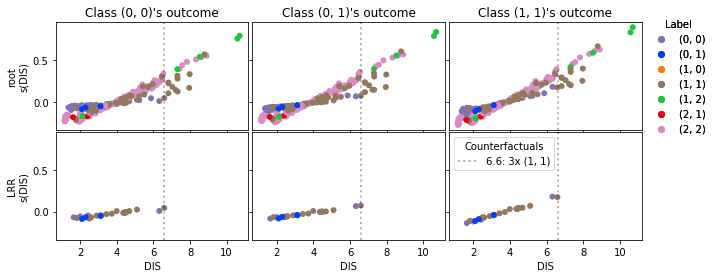

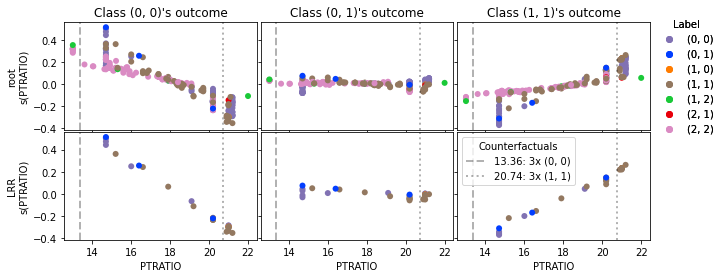

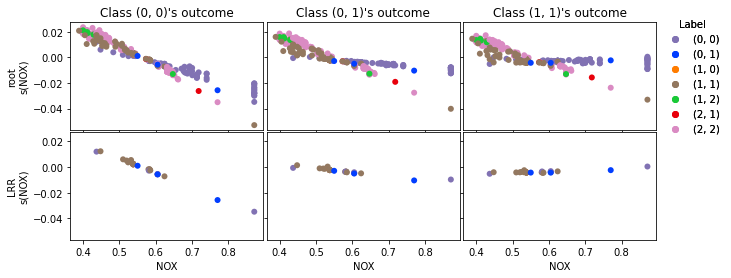

In [28]:
node.plot_feature_dependence(*feature_names[node.diffclf_feature_order[1:]], classes=classes, focus=node.descend())

## $(1,0)$

In [29]:
node.focus_class = '(1, 0)'
classes = ['(0, 0)', '(1, 0)', '(1, 1)']
node.class_counts, node.distance

((2, 2)    96
 (0, 0)    86
 (1, 1)    52
 (1, 2)     5
 (0, 1)     3
 (2, 1)     2
 (1, 0)     2
 dtype: int64,
 149.33968539846273)

In [30]:
print(node.rule_from_counterfactuals()[0])

16.33 < LSTAT <= 16.71 and ZN <= 0 and 7.13 < INDUS <= 9.14 and 0.6 < CRIM <= 1.1 and 5.22 < RM <= 5.75 and RAD <= 5.93 and 288 < TAX <= 326 and AGE > 1 and DIS > 2.93 and 20.58 < PTRATIO <= 21.38


In [31]:
focus = node.descend().get_parent(8)
focus

LRR

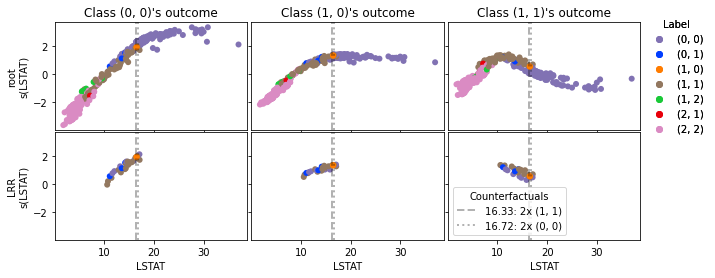

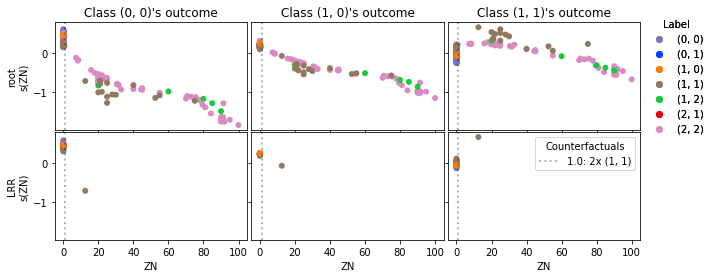

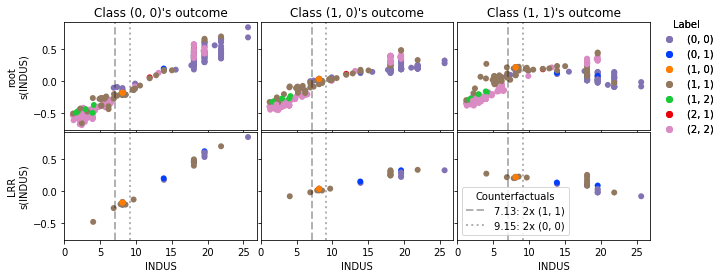

In [32]:
node.plot_feature_dependence(*feature_names[node.diffclf_feature_order[0:3]], classes=classes, focus=focus)

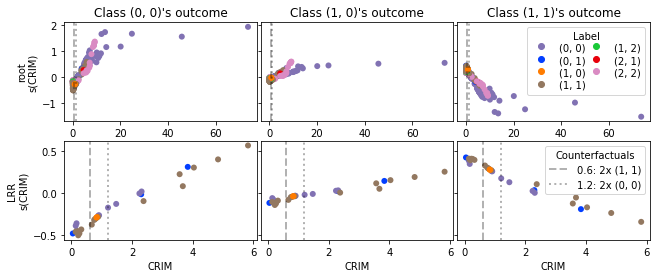

In [33]:
plot_dependence_curves_for_nodes(node, focus, feature='CRIM', labels=classes, show_legend=False, separate_rows=True)
fig = plt.gca().figure
ax = fig.axes[2]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/boston4-depplots-10-crim.pdf', bbox_inches='tight', pad_inches=0)

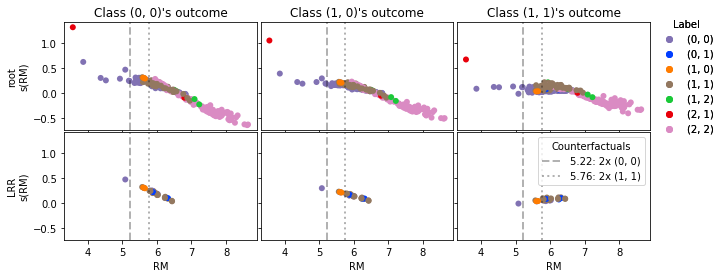

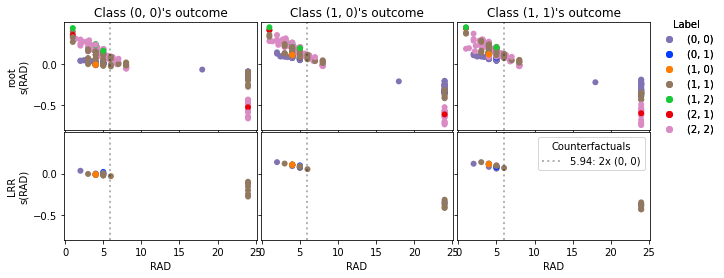

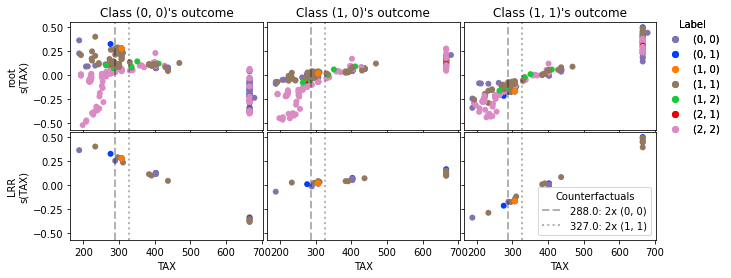

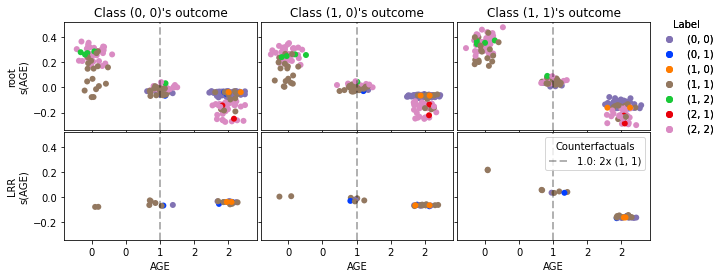

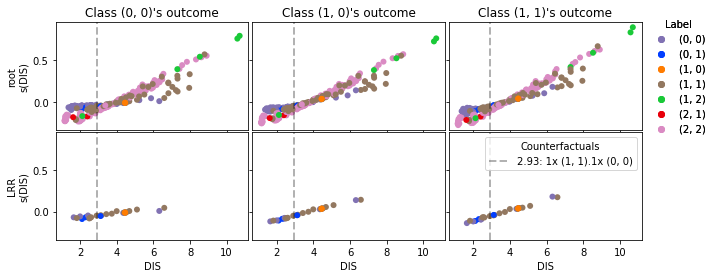

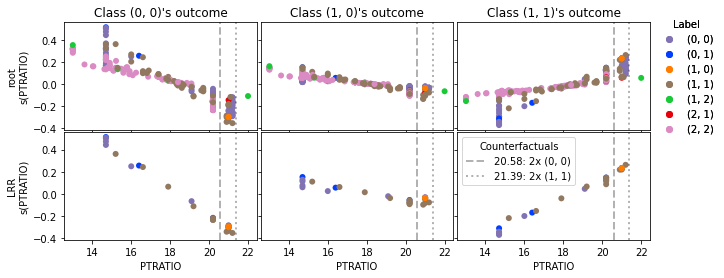

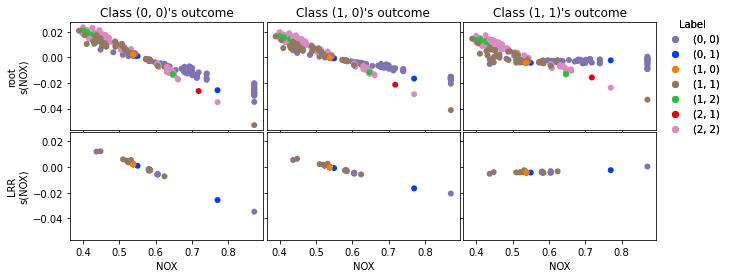

In [34]:
node.plot_feature_dependence(*feature_names[node.diffclf_feature_order[4:]], classes=classes, focus=focus)

## $(1,2)$

In [35]:
node.focus_class = '(1, 2)'
classes = ['(1, 1)', '(1, 2)', '(2, 2)']
node.class_counts, node.distance

((2, 2)    96
 (0, 0)    86
 (1, 1)    52
 (1, 2)     5
 (0, 1)     3
 (2, 1)     2
 (1, 0)     2
 dtype: int64,
 149.33968539846273)

In [36]:
print(node.rule_from_counterfactuals()[0])

3.58 < LSTAT <= 11.58 and ZN > 16 and INDUS <= 16.12 and CRIM <= 42.3 and RM <= 8.63 and RAD <= 13.35 and AGE <= 1 and DIS > 1.94


In [37]:
focus = node.descend()
focus, focus.class_counts, focus.distance

(R,
 (2, 2)    96
 (1, 1)    35
 (1, 2)     5
 (2, 1)     2
 dtype: int64,
 80.73292334198608)

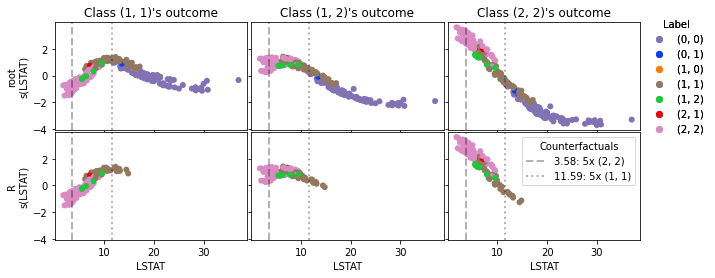

In [38]:
node.plot_feature_dependence(feature_names[node.diffclf_feature_order[0]], classes=classes, focus=focus)

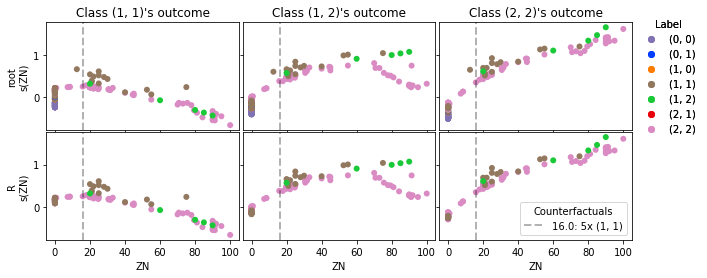

In [39]:
node.plot_feature_dependence(feature_names[node.diffclf_feature_order[1]], classes=classes, focus=focus)

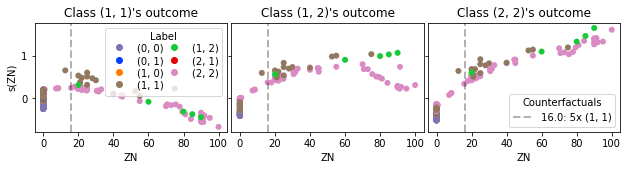

In [40]:
node.plot_feature_dependence(feature_names[node.diffclf_feature_order[1]], classes=classes, show_legend=False)
fig = plt.gca().figure
ax = fig.axes[0]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/boston4-depplots-12-zn.pdf', bbox_inches='tight', pad_inches=0)

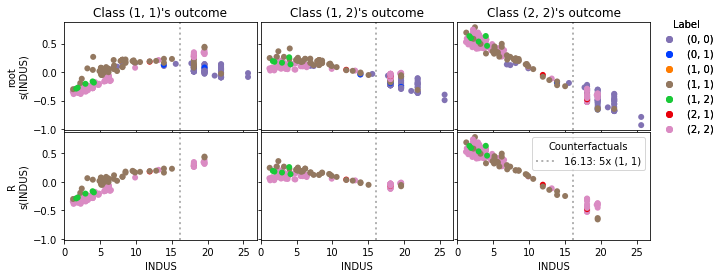

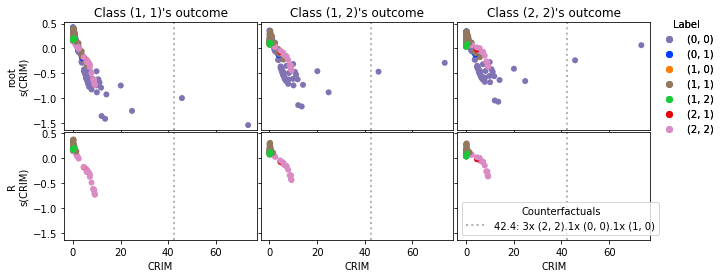

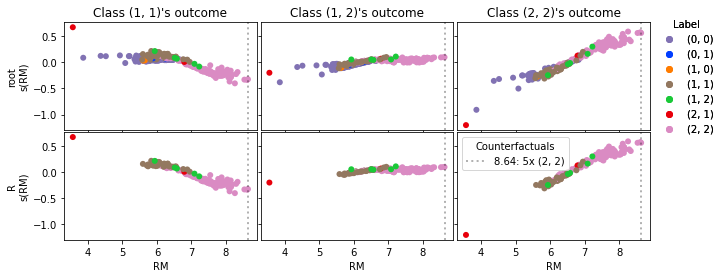

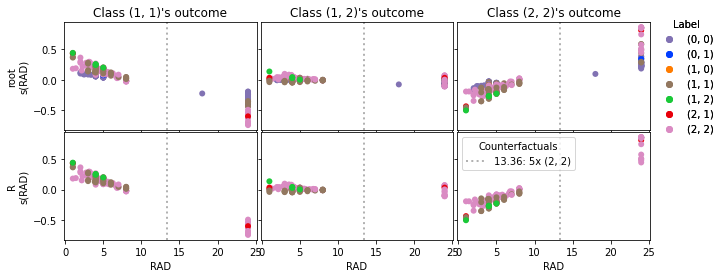

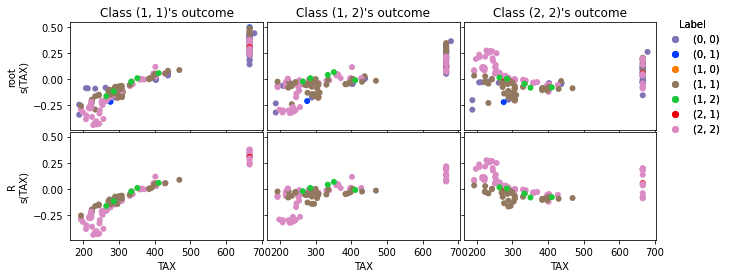

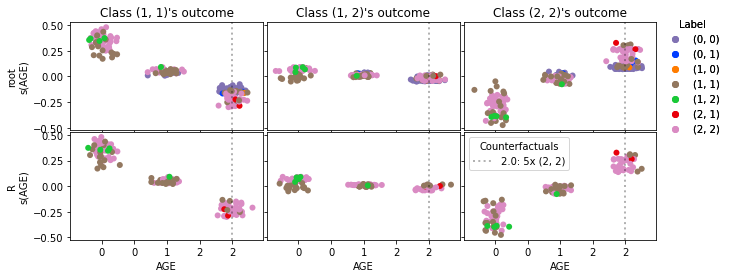

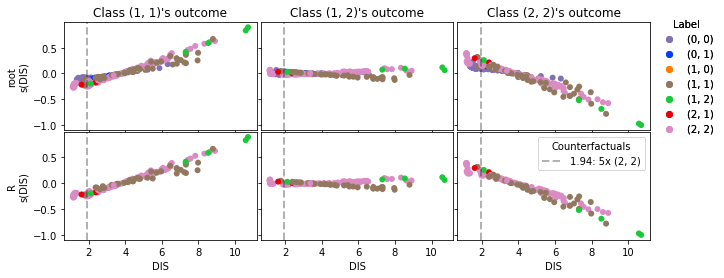

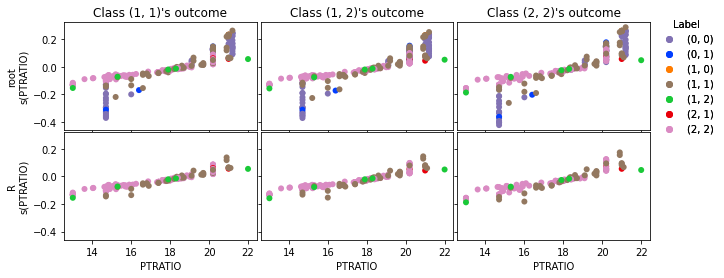

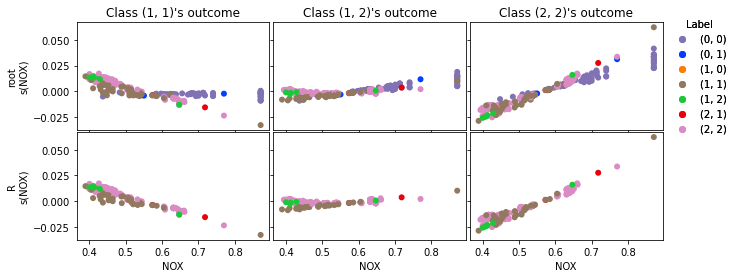

In [41]:
node.plot_feature_dependence(*feature_names[node.diffclf_feature_order[2:]], classes=classes, focus=focus)

## $(2,1)$

In [42]:
node.focus_class = '(2, 1)'
classes = ['(1, 1)', '(2, 1)', '(2, 2)']
node.class_counts, node.distance

((2, 2)    96
 (0, 0)    86
 (1, 1)    52
 (1, 2)     5
 (0, 1)     3
 (2, 1)     2
 (1, 0)     2
 dtype: int64,
 149.33968539846273)

In [43]:
print(node.rule_from_counterfactuals()[0])

6.05 < LSTAT <= 7.41 and ZN <= 18 and 9.80 < INDUS <= 19.61 and CRIM <= 8.6 and RM <= 7.17 and AGE > 1 and DIS <= 4.17


In [44]:
print(node.descend().get_left().rule_from_counterfactuals()[0])

6.05 < LSTAT <= 7.31 and 9.80 < INDUS <= 16.31 and CRIM <= 2.2 and ZN <= 6 and RAD <= 3.23 and AGE > 1 and 1.44 < DIS <= 4.17 and 6.06 < RM <= 7.17


In [45]:
print(node.descend().get_right().rule_from_counterfactuals()[0])

6.06 < LSTAT <= 7.41 and RAD > 22.57 and 0.3 < CRIM <= 8.6 and 10.73 < INDUS <= 19.61 and TAX > 301 and ZN <= 18 and DIS <= 2.24 and RM <= 4.53 and AGE > 1 and PTRATIO > 13.03


In [46]:
focus = node.descend()
focus

RRL

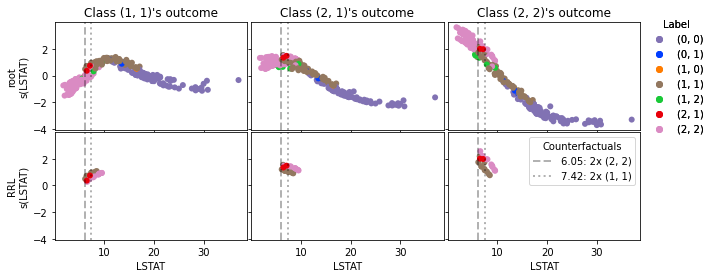

In [47]:
node.plot_feature_dependence(feature_names[focus.diffclf_feature_order[0]], classes=classes, focus=focus)

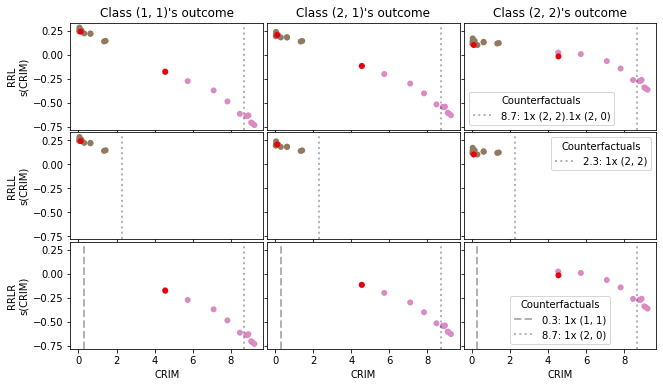

In [48]:
plot_dependence_curves_for_nodes(focus, focus.descend().get_left(), focus.descend().get_right(), feature=feature_names[focus.diffclf_feature_order[1]], labels=classes, show_legend=False)
plt.savefig('figures/boston4-depplots-21-crim.pdf', bbox_inches='tight', pad_inches=0)

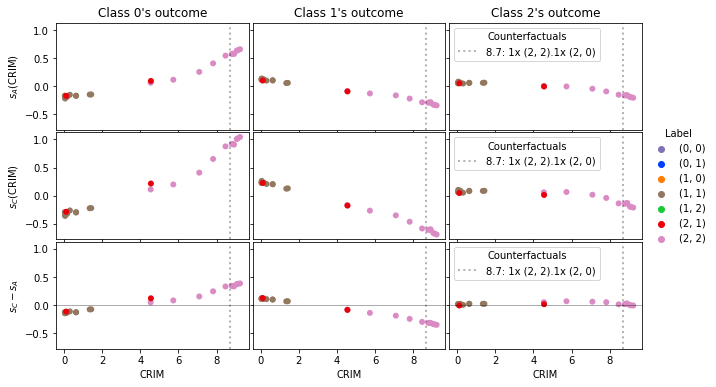

In [49]:
focus.plot_indiv_feature_dependence(feature_names[focus.diffclf_feature_order[1]])

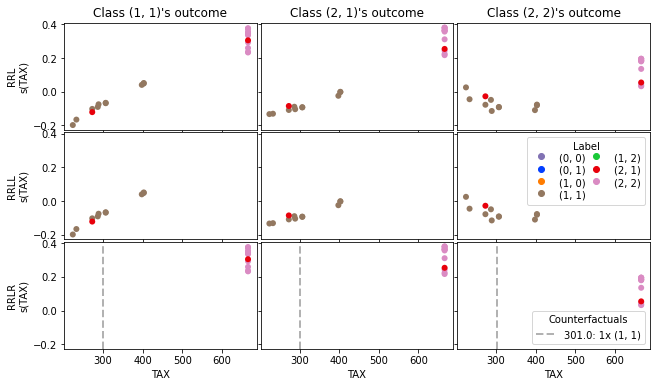

In [50]:
plot_dependence_curves_for_nodes(focus, focus.descend().get_left(), focus.descend().get_right(), feature='TAX', labels=classes, show_legend=False)
fig = plt.gca().figure
ax = fig.axes[5]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/boston4-depplots-21-tax.pdf', bbox_inches='tight', pad_inches=0)

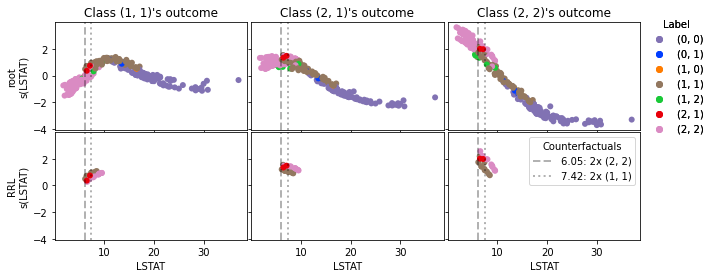

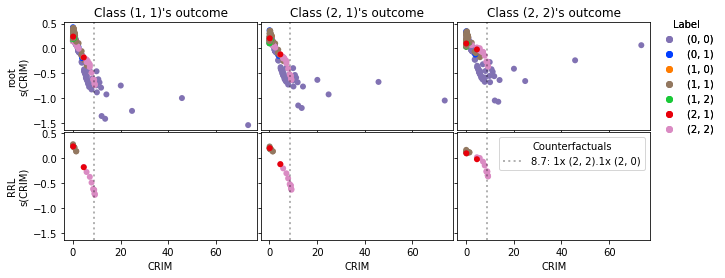

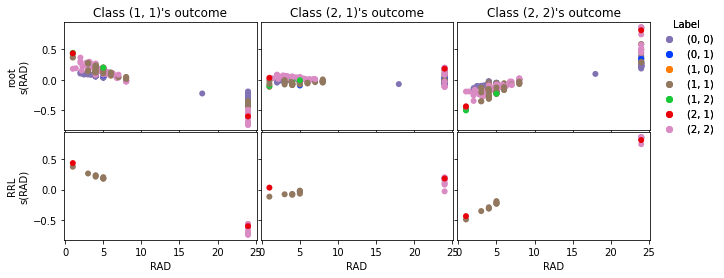

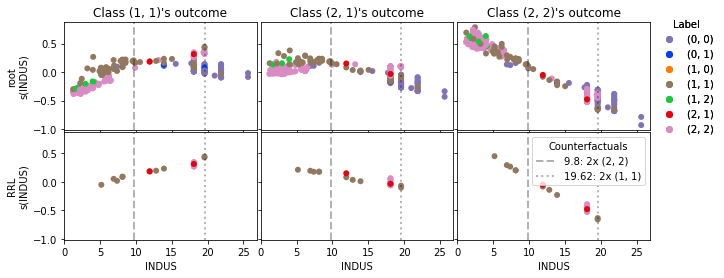

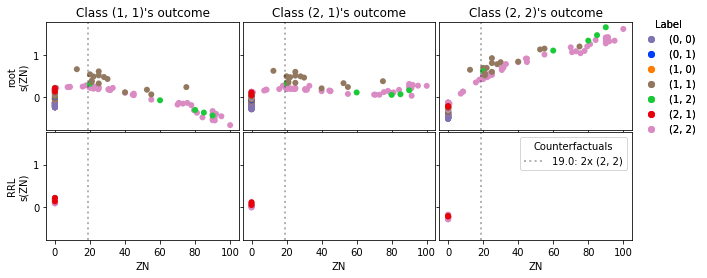

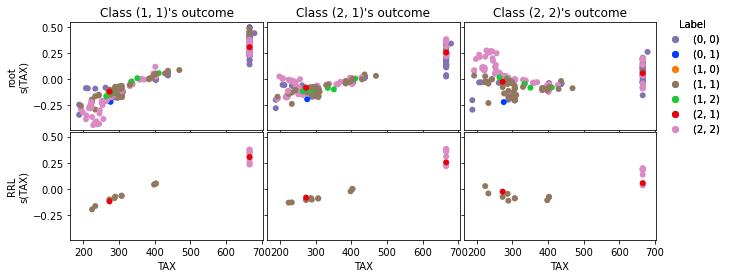

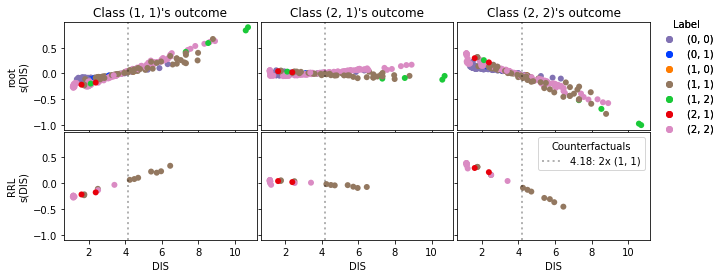

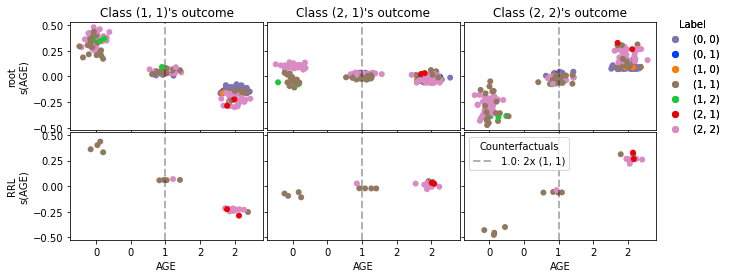

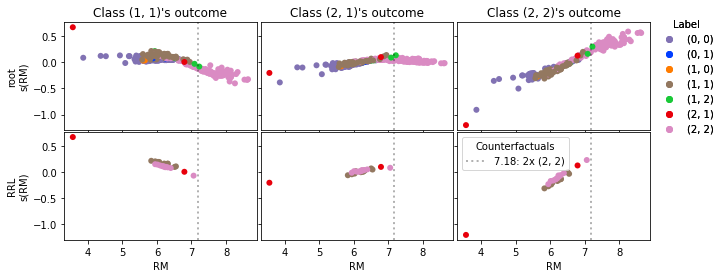

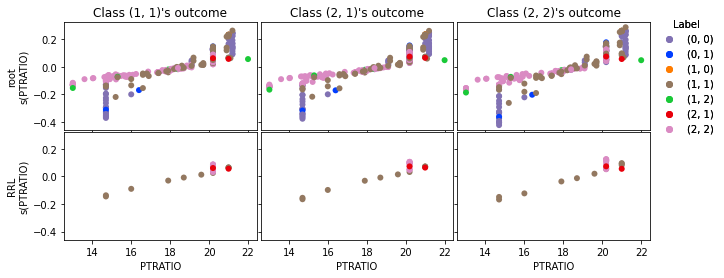

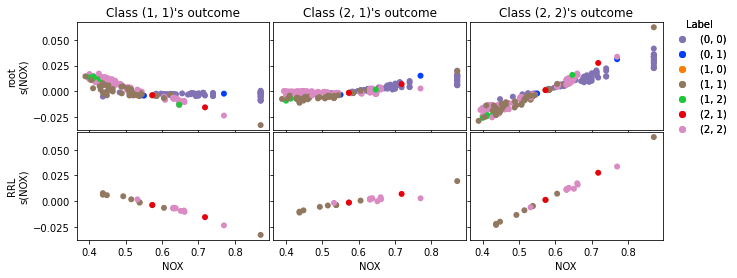

In [51]:
node.plot_feature_dependence(classes=classes, focus=focus)